In [1]:
import torch
import torch.nn as nn

import clip
import numpy as np


### 1. CLIP

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

In [ ]:
model, preprocess = clip.load("ViT-B/32")
input_resolution = model.visual.input_resolution

print("Input resolution:", input_resolution)

In [ ]:
trans = model.transformer
trans

### 2. Data

#### 2.0.0 CSI $\rightarrow$ CSI-Ratio

In [27]:
import numpy as np
import math
from scipy.io import loadmat


# 假设CSI数据的形状为 (num_packets, num_antennas, num_subcarriers)
# num_packets: 数据包数量（时间序列）
# num_antennas: 天线数量（3根天线）
# num_subcarriers: 子载波数量（30个子载波）

def calculate_amplitude_variance_ratio(csi_data):
    """
    计算每个天线的所有子载波的幅度方差比之和
    :param csi_data: CSI数据，形状为 (num_packets, num_antennas, num_subcarriers)
    :return: 每个天线的幅度方差比之和，形状为 (num_antennas,)
    """
    # 计算幅度
    amplitude = np.abs(csi_data)  # 形状为 (num_packets, num_antennas, num_subcarriers)

    # 计算每个天线和子载波的幅度方差
    variance = np.var(amplitude, axis=0)  # 形状为 (num_antennas, num_subcarriers)

    # 计算每个天线的幅度方差比之和
    variance_ratio_sum = np.sum(variance, axis=1)  # 形状为 (num_antennas,)

    return variance_ratio_sum

def select_reference_antenna(csi_data):
    """
    选择参考天线（幅度方差比之和最小的天线）
    :param csi_data: CSI数据，形状为 (num_packets, num_antennas, num_subcarriers)
    :return: 参考天线的索引
    """
    variance_ratio_sum = calculate_amplitude_variance_ratio(csi_data)
    reference_antenna_index = np.argmin(variance_ratio_sum)
    return reference_antenna_index

def calculate_csi_ratio(csi_data):
    """
    计算CSI比值（CSI-Ratio）
    :param csi_data: CSI数据，形状为 (num_packets, num_antennas, num_subcarriers)
    :return: CSI比值数据，形状为 (num_packets, num_antennas, num_subcarriers)
    """
    num_packets, num_antennas, num_subcarriers = csi_data.shape

    # 选择参考天线
    reference_antenna_index = select_reference_antenna(csi_data)
    reference_csi = csi_data[:, reference_antenna_index, :]  # 参考天线的CSI数据

    # 计算CSI比值
    csi_ratio = np.zeros_like(csi_data)
    for antenna in range(num_antennas):
        if antenna == reference_antenna_index:
            # 参考天线的CSI比值为1
            csi_ratio[:, antenna, :] = 1.0
        else:
            # 其他天线的CSI比值
            csi_ratio[:, antenna, :] = csi_data[:, antenna, :] / reference_csi

    return csi_ratio, reference_antenna_index

In [28]:
csi_data = loadmat("../CSI-Data-Fu/user1-1-1-1-1-r2.mat")
csi_data = csi_data['csi_data']
csi_data = csi_data.reshape(csi_data.shape[0], 3, -1)

In [29]:
# 计算CSI比值
csi_ratio, reference_antenna = calculate_csi_ratio(csi_data)
# 输出结果
print("CSI比值数据的形状:", csi_ratio.shape)
print("参考天线的索引:", reference_antenna)

CSI比值数据的形状: (1990, 3, 30)
参考天线的索引: 1


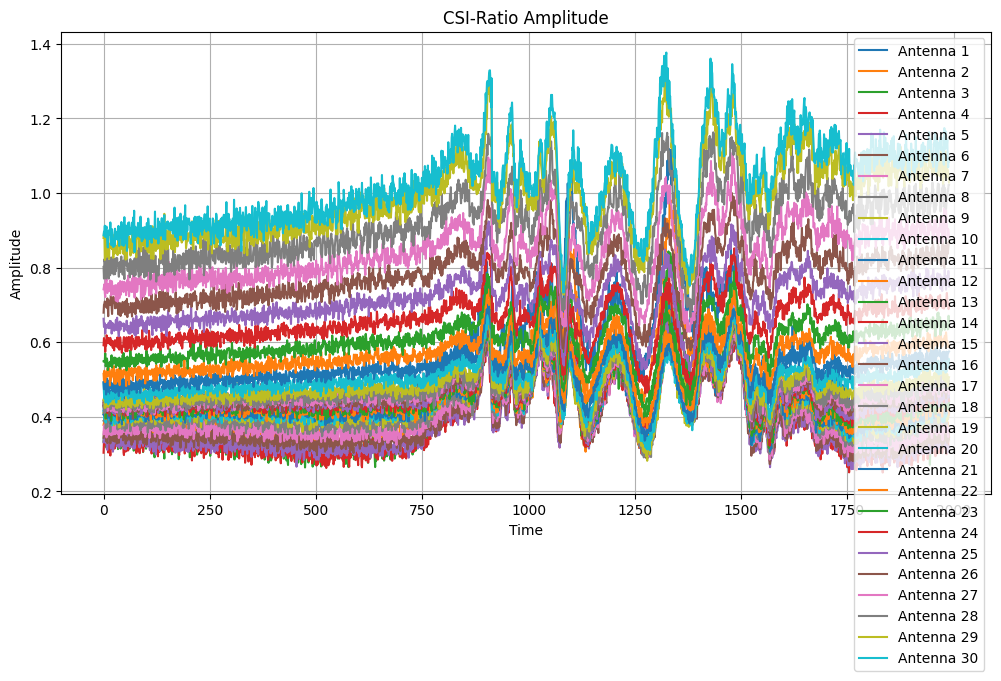

In [31]:
import matplotlib.pyplot as plt

abs_csi_ratio = np.abs(csi_ratio)
plt.figure(figsize=(12, 6))
for i in range(0, 30):
    plt.plot(abs_csi_ratio[:, 2, i], label=f'Antenna {i+1}')

plt.title('CSI-Ratio Amplitude')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

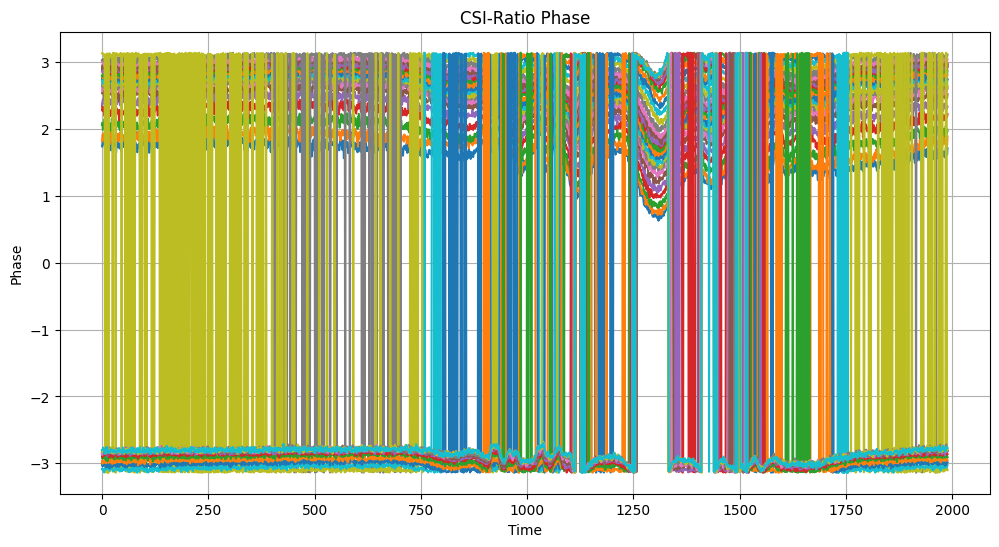

In [32]:
angle_csi_ratio = np.angle(csi_ratio)
plt.figure(figsize=(12, 6))
for i in range(0, 30):
    plt.plot(angle_csi_ratio[:, 2, i], label=f'Antenna {i+1}')

plt.title('CSI-Ratio Phase')
plt.xlabel('Time')
plt.ylabel('Phase')
plt.grid(True)
plt.show()

#### 2.0.1 Denoie CSI-Ratio Phase

In [33]:
def hampel_filter(data, window_size=5, n_sigmas=3):
    """
    使用Hampel滤波器去除时间序列中的异常值。
    
    :param data: 输入的时间序列数据，形状为 (num_packets, num_antennas, num_subcarriers)
    :param window_size: 计算中位数和MAD的窗口大小
    :param n_sigmas: 阈值的倍数
    :return: 去除异常值后的时间序列数据
    """
    filtered_data = np.copy(data)
    num_packets, num_antennas, num_subcarriers = data.shape
    
    for ant in range(num_antennas):
        for sc in range(num_subcarriers):
            sequence = data[:, ant, sc]
            median = np.median(sequence)
            deviation = np.abs(sequence - median)
            mad = np.median(deviation)
            
            # 计算阈值
            threshold = n_sigmas * mad
            
            # 检测异常值
            outliers = deviation > threshold
            
            # 替换异常值为中位数
            filtered_data[outliers, ant, sc] = median
    
    return filtered_data

In [34]:
def phase_calibration(phase_data, epsilon=0.3):
    """
    对CSI-Ratio的相位数据进行相位校准。
    
    参数:
    phase_data: numpy数组，形状为(num_packets, num_antennas, num_subcarriers)，包含相位数据。
    epsilon: 浮点数，经验性设置的阈值，默认为0.3。
    
    返回:
    校准后的相位数据，形状与phase_data相同。
    """
    calibrated_phase_data = phase_data.copy()
    num_packets, num_antennas, num_subcarriers = phase_data.shape
    
    for ant in range(num_antennas):
        for sc in range(num_subcarriers):
            for t in range(1, num_packets):
                phase_diff = calibrated_phase_data[t, ant, sc] - calibrated_phase_data[t-1, ant, sc]
                while abs(phase_diff) > 2 * np.pi - epsilon:
                    if phase_diff > 0:
                        calibrated_phase_data[t, ant, sc] -= 2 * np.pi
                    else:
                        calibrated_phase_data[t, ant, sc] += 2 * np.pi
                    phase_diff = calibrated_phase_data[t, ant, sc] - calibrated_phase_data[t-1, ant, sc]
    
    return calibrated_phase_data

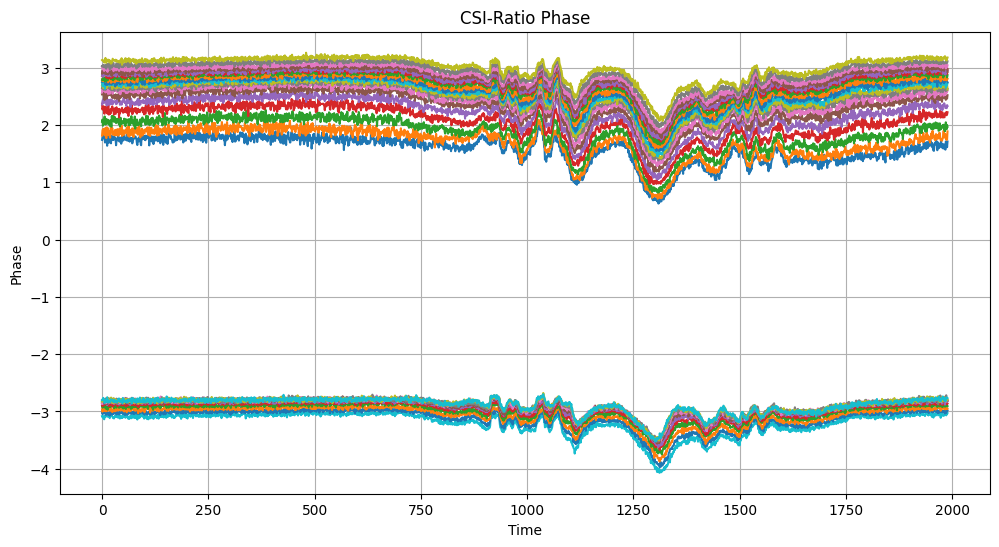

In [36]:
# 进行相位校准
angle_csi_ratio = phase_calibration(angle_csi_ratio)

plt.figure(figsize=(12, 6))
for i in range(0, 30):
    plt.plot(angle_csi_ratio[:, 2, i], label=f'Antenna {i+1}')

plt.title('CSI-Ratio Phase')
plt.xlabel('Time')
plt.ylabel('Phase')
plt.grid(True)
plt.show()

#### 2.0.2 CSI Resample

In [45]:
import numpy as np
from scipy.interpolate import interp1d, CubicSpline, splev, splrep

def resample_csi_sequence(csi_sequence, target_length=500, sample_way='linear'):
    """
    对单个CSI序列进行重采样至目标长度
    :param csi_sequence: 原始CSI序列，形状为 (original_length, num_antennas, num_subcarriers)
    :param target_length: 目标序列长度（默认为500）
    :param sample_way: 插值方式，可选 'linear', 'cubic', 'spline'（默认为 'linear'）
    :return: 重采样后的CSI序列，形状为 (target_length, num_antennas, num_subcarriers)
    """
    original_length = csi_sequence.shape[0]
    num_antennas = csi_sequence.shape[1]
    num_subcarriers = csi_sequence.shape[2]
    
    # 创建新时间轴
    original_time = np.linspace(0, 1, original_length)  # 归一化时间轴
    new_time = np.linspace(0, 1, target_length)          # 目标时间轴
    
    # 初始化输出序列
    resampled_sequence = np.zeros((target_length, num_antennas, num_subcarriers), dtype=csi_sequence.dtype)
    
    # 对每个天线和子载波进行插值
    for ant in range(num_antennas):
        for sc in range(num_subcarriers):
            # 提取原始序列
            cur_sequence = csi_sequence[:, ant, sc]
            
            # 检查数据类型
            if np.iscomplexobj(cur_sequence):
                # 如果是复数，分别处理实部和虚部
                real_part = np.real(cur_sequence)
                imag_part = np.imag(cur_sequence)
                
                # 根据插值方式选择插值函数
                if sample_way == 'linear':
                    interp_real = interp1d(original_time, real_part, kind='linear')
                    interp_imag = interp1d(original_time, imag_part, kind='linear')
                elif sample_way == 'cubic':
                    interp_real = CubicSpline(original_time, real_part)
                    interp_imag = CubicSpline(original_time, imag_part)
                elif sample_way == 'spline':
                    tck_real = splrep(original_time, real_part, k=3)
                    tck_imag = splrep(original_time, imag_part, k=3)
                    interp_real = lambda x: splev(x, tck_real)
                    interp_imag = lambda x: splev(x, tck_imag)
                else:
                    raise ValueError("Unsupported sample_way. Choose 'linear', 'cubic', or 'spline'.")
                
                # 生成新序列
                resampled_real = interp_real(new_time)
                resampled_imag = interp_imag(new_time)
                
                # 合并实部和虚部
                resampled_sequence[:, ant, sc] = resampled_real + 1j * resampled_imag
            else:
                # 如果是实数，直接插值
                if sample_way == 'linear':
                    interp_fun = interp1d(original_time, cur_sequence, kind='linear')
                elif sample_way == 'cubic':
                    interp_fun = CubicSpline(original_time, cur_sequence)
                elif sample_way == 'spline':
                    tck = splrep(original_time, cur_sequence, k=3)
                    interp_fun = lambda x: splev(x, tck)
                else:
                    raise ValueError("Unsupported sample_way. Choose 'linear', 'cubic', or 'spline'.")
                
                # 生成新序列
                resampled_sequence[:, ant, sc] = interp_fun(new_time)
            
    return resampled_sequence

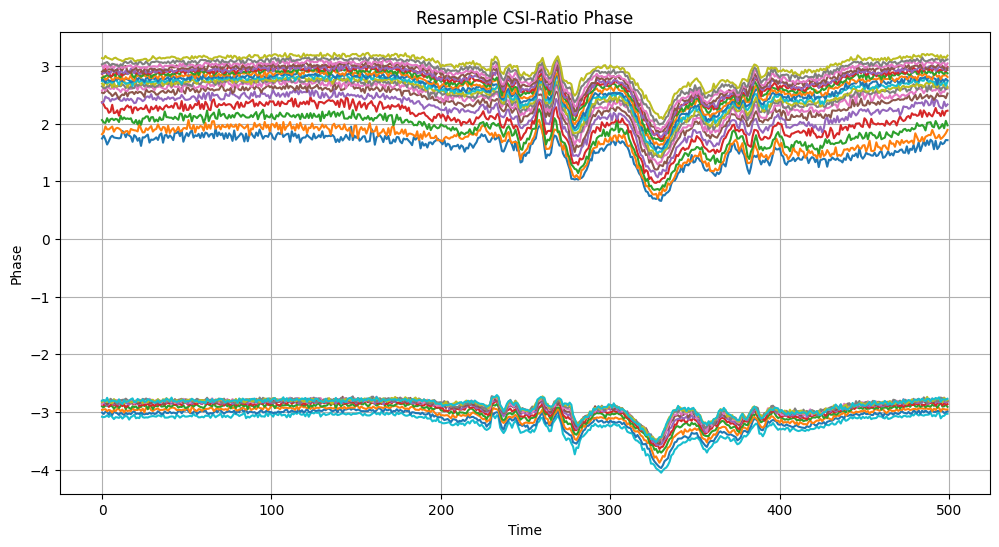

In [47]:
# 执行重采样
resampled_data = resample_csi_sequence(angle_csi_ratio, 500, sample_way='cubic')

# 验证输出形状
plt.figure(figsize=(12, 6))
for i in range(0, 30):
    plt.plot(resampled_data[:, 2, i], label=f'Antenna {i+1}')

plt.title('Resample CSI-Ratio Phase')
plt.xlabel('Time')
plt.ylabel('Phase')
plt.grid(True)
plt.show()

#### 2.0.4 CSI DWT (小波变换)

In [1]:
# 小波变换去噪
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pywt

def wavelet_denoise(signal, wavelet='db4', level=None, threshold_mode='soft', mode='sym'):
    """
    对一维信号进行小波去噪，支持实数和复数信号。
    """
    if np.iscomplexobj(signal):
        # 复数信号分解为实部和虚部分别处理
        real_part = np.real(signal)
        imag_part = np.imag(signal)
        denoised_real = wavelet_denoise(real_part, wavelet, level, threshold_mode, mode)
        denoised_imag = wavelet_denoise(imag_part, wavelet, level, threshold_mode, mode)
        return denoised_real + 1j * denoised_imag
    else:
        # 实数信号处理
        # 自动计算最大分解层数（如果未指定）
        if level is None:
            level = pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len)
            # 如果信号长度不足以进行小波分解，则返回原信号
            if level == 0:
                return signal
        
        try:
            coeffs = pywt.wavedec(signal, wavelet, level=level, mode=mode)
        except ValueError:
            # 分解层数过高，降低层数
            level = pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len)
            if level == 0:
                return signal
            coeffs = pywt.wavedec(signal, wavelet, level=level, mode=mode)
        
        if len(coeffs) < 2:
            return signal
        
        # 使用最高层细节系数估计噪声标准差
        sigma = np.median(np.abs(coeffs[-1])) / 0.6745
        threshold = sigma * np.sqrt(2 * np.log(len(signal)))
        
        # 阈值处理细节系数
        coeffs_thresholded = [coeffs[0]]  # 保留近似系数
        for i in range(1, len(coeffs)):
            coeffs_thresholded.append(pywt.threshold(coeffs[i], threshold, mode=threshold_mode))
        
        # 重构信号
        denoised_signal = pywt.waverec(coeffs_thresholded, wavelet, mode=mode)
        
        # 确保长度一致
        if len(denoised_signal) != len(signal):
            denoised_signal = np.resize(denoised_signal, len(signal))
        
        return denoised_signal

def denoise_csi_data(csi_data, wavelet='db4', level=None, threshold_mode='soft', mode='sym', n_jobs=None):
    """
    对CSI数据进行小波去噪（支持并行处理）
    
    参数:
        csi_data: 三维CSI数据，形状为(num_packets, num_antennas, num_subcarriers)
        n_jobs: 并行任务数（None表示串行处理）
    """
    num_packets, num_antennas, num_subcarriers = csi_data.shape
    csi_denoised = np.zeros_like(csi_data)
    
    # 并行处理
    if n_jobs is not None and n_jobs != 1:
        from joblib import Parallel, delayed
        results = Parallel(n_jobs=n_jobs)(
            delayed(wavelet_denoise)(csi_data[:, i, j], wavelet, level, threshold_mode, mode)
            for i in range(num_antennas)
            for j in range(num_subcarriers)
        )
        
        idx = 0
        for i in range(num_antennas):
            for j in range(num_subcarriers):
                csi_denoised[:, i, j] = results[idx]
                idx += 1
    else:
        # 串行处理
        for i in range(num_antennas):
            for j in range(num_subcarriers):
                csi_denoised[:, i, j] = wavelet_denoise(
                    csi_data[:, i, j], 
                    wavelet=wavelet,
                    level=level,
                    threshold_mode=threshold_mode,
                    mode=mode
                )
    
    return csi_denoised

In [3]:
# 生成示例CSI数据（复数）
csi_data = loadmat('../CSI-Data-Fu/user1-1-1-1-1-r2.mat')['csi_data']
csi_data = csi_data.reshape(csi_data.shape[0], 3, -1)
abs_csi = np.abs(csi_data)
# 去噪处理（使用4个并行进程）
csi_denoised = denoise_csi_data(abs_csi,level=5,wavelet='sym8')

Text(0, 0.5, 'Amplitude')

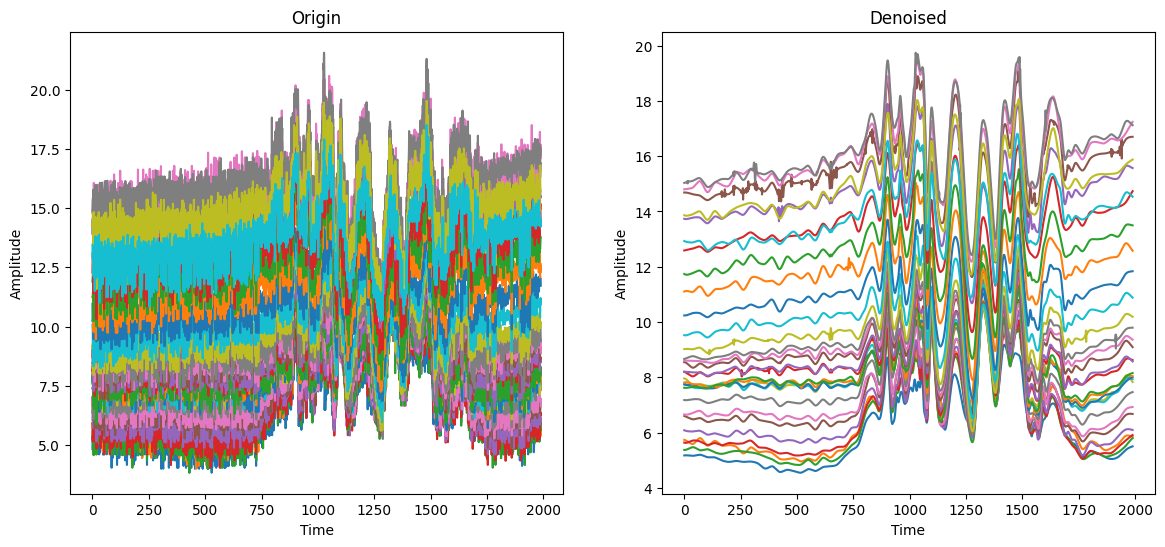

In [4]:
# 绘制两幅图像 csi_data && csi_denoised
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i in range(0,30):
    plt.plot(abs_csi[:,2,i])
plt.title('Origin')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(1, 2, 2)
for i in range(0,30):
    plt.plot(csi_denoised[:,2,i])
plt.title('Denoised')
plt.xlabel('Time')
plt.ylabel('Amplitude')

#### 2.0.5 CSI PCA+STFT

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.signal import stft

def apply_pca(amplitude_data, n_components=10):
    """
    对幅度数据进行PCA降维。
    
    :param amplitude_data: 幅度数据，形状为 (num_packets, num_antennas, num_subcarriers)
    :param n_components: 降维后的主成分数量
    :return: 降维后的数据，形状为 (num_packets, num_antennas, n_components)
    """
    num_packets, num_antennas, num_subcarriers = amplitude_data.shape
    pca = PCA(n_components=n_components)
    
    # 对每个天线和子载波进行PCA降维
    pca_data = np.zeros((num_packets, num_antennas, n_components))
    for ant in range(num_antennas):
        pca_data[:, ant, :] = pca.fit_transform(amplitude_data[:, ant, :])
    
    return pca_data

def apply_stft(pca_data, fs=1.0, window='hann', nperseg=256, noverlap=None):
    """
    对降维后的数据进行短时傅里叶变换。
    :param pca_data: 降维后的数据，形状为 (num_packets, num_antennas, n_components)
    :param fs: 采样频率
    :param window: 窗口函数
    :param nperseg: 每个分段的长度
    :param noverlap: 分段之间的重叠长度
    :return: STFT结果，形状为 (num_antennas, n_components, n_freqs, n_segments)
    """
    num_packets, num_antennas, n_components = pca_data.shape
    stft_results = []
    
    for ant in range(num_antennas):
        for comp in range(n_components):
            f, t, Zxx = stft(pca_data[:, ant, comp], fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
            stft_results.append(Zxx)
    
    stft_results = np.array(stft_results).reshape(num_antennas, n_components, *Zxx.shape)
    return f, t, stft_results


In [25]:
csi_data = loadmat("../CSI-Data-Fu/user1-1-1-1-1-r2.mat")
csi_data = csi_data['csi_data']
csi_data = csi_data.reshape(csi_data.shape[0], 3, -1)

# 计算幅度
amplitude_data = np.abs(csi_data)

# PCA降维
pca_data = apply_pca(amplitude_data, n_components=10)

# 短时傅里叶变换
fs = 1.0  # 假设采样频率为1 Hz
window = 'hann'
nperseg = 256
noverlap = 128

f, t, stft_results = apply_stft(pca_data, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)

# 输出结果
print("STFT结果形状:", stft_results.shape)

STFT结果形状: (3, 10, 129, 17)


#### 2.0.6 Extract DFS from CSI

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import stft
from sklearn.decomposition import PCA

def get_doppler_spectrum(csi_data, method='stft'):
    '''
    param: csi_data: 输入的CSI数据, shape为(time_length, rx_acnt, subcarrier_num)
    param: rx_acnt: 接收天线数量
    '''
    time, rx_acnt, subcarrier_num = csi_data.shape

    # Set-Up Parameters
    samp_rate = 1000
    half_rate = samp_rate / 2
    uppe_orde = 6
    uppe_stop = 60
    lowe_orde = 3
    lowe_stop = 2

    # Butterworth滤波器设计
    lu, ld = butter(uppe_orde, uppe_stop / half_rate, 'low')
    hu, hd = butter(lowe_orde, lowe_stop / half_rate, 'high')

    # 频率分箱
    freq_bins_unwrap = np.concatenate([np.arange(0, samp_rate/2), np.arange(-samp_rate/2, 0)])
    freq_bins_unwrap = freq_bins_unwrap / samp_rate
    freq_lpf_sele = (freq_bins_unwrap <= uppe_stop / samp_rate) & (freq_bins_unwrap >= -uppe_stop / samp_rate)
    freq_lpf_positive_max = np.sum(freq_lpf_sele[1:int(len(freq_lpf_sele)/2)])
    freq_lpf_negative_min = np.sum(freq_lpf_sele[int(len(freq_lpf_sele)/2):])

    # 多普勒频谱初始化
    csi_data = denoise_csi_data(csi_data)
    doppler_spectrum = np.zeros((1 + int(freq_lpf_positive_max) + int(freq_lpf_negative_min), int(np.floor(csi_data.shape[0]))))

    # 降采样
    csi_data = csi_data[::1, :, :]

    # 选择天线对
    csi_mean = np.mean(np.abs(csi_data), axis=0)
    csi_var = np.sqrt(np.var(np.abs(csi_data), axis=0))
    csi_mean_var_ratio = csi_mean / csi_var
    idx = np.argmax(np.mean(csi_mean_var_ratio, axis=-1))
    csi_data_ref = np.tile(csi_data[:, idx, :], (1, rx_acnt)).reshape(time, rx_acnt, -1)

    # 幅度调整
    csi_data_adj = np.zeros_like(csi_data)
    csi_data_ref_adj = np.zeros_like(csi_data_ref)
    alpha_sum = 0
    for acnt in range(rx_acnt):
        for subcarrier in range(subcarrier_num):
            amp = np.abs(csi_data[:, acnt, subcarrier])
            alpha = np.min(amp[amp != 0])
            alpha_sum += alpha
            csi_data_adj[:, acnt, subcarrier] = (np.abs(csi_data[:, acnt, subcarrier]) - alpha) * np.exp(1j * np.angle(csi_data[:, acnt, subcarrier]))
    beta = 1000 * alpha_sum / (subcarrier_num * rx_acnt)
    for acnt in range(rx_acnt):
        for subcarrier in range(subcarrier_num):
            csi_data_ref_adj[:, acnt, subcarrier] = (np.abs(csi_data_ref[:, acnt, subcarrier]) + beta) * np.exp(1j * np.angle(csi_data_ref[:, acnt, subcarrier]))

    # 共轭乘法
    conj_mult = csi_data_adj * np.conj(csi_data_ref_adj)
    conj_mult = np.concatenate([conj_mult[:, :idx, :], conj_mult[:, idx+1:, :]], axis=1)

    # 滤波
    for acnt in range(rx_acnt-1):
        for subcarrier in range(subcarrier_num):
            conj_mult[:, acnt, subcarrier] = filtfilt(lu, ld, conj_mult[:, acnt, subcarrier])
            conj_mult[:, acnt, subcarrier] = filtfilt(hu, hd, conj_mult[:, acnt, subcarrier])

    # PCA分析
    pca = PCA(n_components=1)
    conj_mult_pca = pca.fit_transform(np.abs(conj_mult.reshape(time, -1)))

    # 时频分析
    if method == 'cwt':
        # 连续小波变换
        freq_time_prof_allfreq = np.abs(pywt.cwt(conj_mult_pca, np.arange(1, samp_rate/2+1), 'cmor4-1')[0])
    elif method == 'stft':
        # 短时傅里叶变换
        f, t, Zxx = stft(conj_mult_pca, fs=samp_rate, window='gauss', nperseg=samp_rate//4+1)
        freq_time_prof_allfreq = np.abs(Zxx)

    # 选择关心的频率
    freq_time_prof = freq_time_prof_allfreq[freq_lpf_sele, :]
    freq_time_prof = freq_time_prof / np.sum(freq_time_prof, axis=0)

    # 频率分箱
    freq_bin = np.concatenate([np.arange(0, freq_lpf_positive_max), np.arange(-freq_lpf_negative_min, 0)])

    # 存储多普勒频谱
    if freq_time_prof.shape[1] >= doppler_spectrum.shape[2]:
        doppler_spectrum[:, :] = freq_time_prof[:, :doppler_spectrum.shape[2]]
    else:
        doppler_spectrum[:, :] = np.concatenate([freq_time_prof, np.zeros((doppler_spectrum.shape[1], doppler_spectrum.shape[2] - freq_time_prof.shape[1]))], axis=1)

    return doppler_spectrum, freq_bin

In [ ]:
# 随机生成CSI数据
csi_data = np.random.rand(300, 3, 30)+1j*np.random.rand(300, 3, 30)

dfs = get_doppler_spectrum(csi_data)

#### 2.1 CSI Dataset 

In [ ]:
import scipy.io as sio
import os
import numpy as np
from typing import List
import random
import pywt

from dataset.data import get_csi_data
from dataset.datasets import CSI_Dataset, HAR_Dataset
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

In [ ]:
# Widar
data_path = '../data'
batch_size = 20
time_length = 2000
req_domains = ['users', 'gesture_type', 'tosor_loc', 'face_ori', 'rec_dev']

In [ ]:
train_datas, train_labels, eval_datas, eval_labels = get_csi_data(
    data_path, 
    req_domains=req_domains,
)

train_labels.shape

In [ ]:
# HAR
train_datas = HAR_Dataset('D:/NTU-Fi_HAR/train_amp', time_length=2000)

#### 2.2 DFS Data

In [ ]:
import scipy.io as sio
import os
import numpy as np
from typing import List
import random
import pywt

from dataset.data import get_dfs_data
from dataset.datasets import DFS_Dataset
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

In [ ]:
dfs_data_path = '../dfs_data'
req_domains = ['users', 'gesture_type', 'tosor_loc', 'face_ori']

In [ ]:
train_datas, train_labels, eval_datas, eval_labels = get_dfs_data(dfs_data_path, req_domains)

In [ ]:
train_dataset = DFS_Dataset(
    dfs_data_path,
    train_datas,
    train_labels
)

### 3.Model

In [ ]:
from model.embed import TokenEmbedding

from einops import rearrange
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


### GPT2

In [7]:
import torch
from transformers import GPT2Tokenizer
from transformers.models.gpt2.modeling_gpt2 import GPT2Model, GPT2Config

In [8]:
gpt2tokenizer = GPT2Tokenizer.from_pretrained('openai-community/gpt2')

d:\Anaconda\envs\pytorch\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Lenove\.cache\huggingface\hub\models--openai-community--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
model_config = GPT2Config.from_pretrained('openai-community/gpt2')
model_config

In [ ]:
# GPT2 Model
model = GPT2Model.from_pretrained('openai-community/gpt2')
model

In [4]:
word_weight = model.get_input_embeddings().weight
word_weight.requires_grad

True

### Qwen2.5-3B

In [ ]:
import torch
from transformers import Qwen2ForCausalLM, Qwen2Model, Qwen2Config

from peft import get_peft_model, LoraConfig, TaskType

In [ ]:
model_config = Qwen2Config.from_pretrained('unsloth/Qwen2.5-3B')
model_config.num_hidden_layers = 12
model_config

In [ ]:
model = Qwen2Model.from_pretrained('unsloth/Qwen2.5-3B', config=model_config)
model

#### Llama-3-8B

In [5]:
import torch
from transformers import LlamaModel, LlamaConfig

In [ ]:
model_config = LlamaConfig.from_pretrained('unsloth/Llama-3.2-1B')
model_config

In [ ]:
model = LlamaModel.from_pretrained('unsloth/Llama-3.2-1B')
model